In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

PseudoData = pd.read_csv('PseudoData.csv')  #Read in CSV

# Preprocessing

In [2]:
PseudoData.loc[1, "Att Rate"] = np.NaN
PseudoData.loc[18, "Att Rate"] = np.NaN
PseudoData.loc[13, "#Honors semesters"] = np.NaN
PseudoData.loc[20, "GPA"] = np.NaN

In [3]:
before_processed_shape = PseudoData.shape[0]
PseudoData = PseudoData.dropna()
after_processed_shape = PseudoData.shape[0]

In [4]:
DiscardedCount = open("demofile.txt", 'a')
DiscardedCount.write("Original Count/Shape:" + str(22))
DiscardedCount.write("\n\nNew Count/Shape:" + str(18))
DiscardedCount.close()

## Correlation Heatmap

In [5]:
PseudoData['#AP/Honors'] = PseudoData['#Honors semesters'] + PseudoData['#AP semesters']
PseudoData = PseudoData[['Student', 'Grade', 'GPA', '#AP/Honors', '#Honors semesters', '#AP semesters', 'Days Enrolled', 'Days Present', 'Att Rate']]
PseudoData['Days Absent'] = PseudoData['Days Enrolled'] - PseudoData['Days Present']
PseudoData = PseudoData[['Student', 'Grade', 'GPA', '#AP/Honors', '#Honors semesters', '#AP semesters', 'Days Absent', 'Days Enrolled', 'Days Present', 'Att Rate']]
PseudoData = PseudoData.drop(labels=['#Honors semesters', '#AP semesters','Days Present'], axis=1)

In [6]:
CorrelationDF = PseudoData.drop(labels=["Student", "Att Rate"], axis=1)

Text(0.5, 1.0, 'Feature Correlation Heatmap')

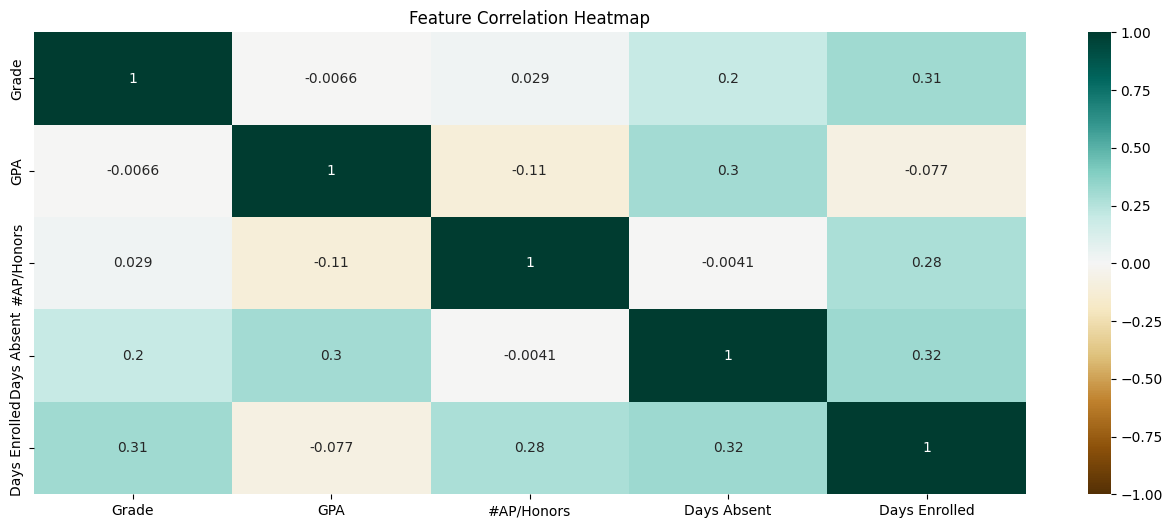

In [7]:
plt.figure(figsize=(16,6))
FeatureHeatMap = sns.heatmap(CorrelationDF.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
FeatureHeatMap.set_title('Feature Correlation Heatmap')


# Stacked Ensmeble Construction

## Base Models (Extra Trees, KNN, and XGB)

In [45]:
from sklearn.model_selection import (train_test_split,GroupKFold, StratifiedGroupKFold, KFold)
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification


In [9]:
PseudoData

,Student,Grade,GPA,#AP/Honors,Days Absent,Days Enrolled,Att Rate
0,20000000,12,4.000,0.0,20.0,169,88.2
2,20000002,12,4.000,1.0,41.0,169,75.7
3,20000003,12,3.750,4.0,18.0,169,89.3
4,20000004,12,3.500,4.0,3.5,169,97.9
5,20000005,11,3.571,0.0,9.0,169,94.7
6,20000006,11,3.231,10.0,1.0,169,99.4
7,20000007,11,4.000,0.0,15.0,169,91.1
8,20000008,11,3.750,0.0,7.0,169,95.9
9,20000009,10,4.000,8.0,26.0,169,84.6
10,20000010,10,3.857,3.0,47.0,169,72.2


In [10]:
TrainingDF = PseudoData.drop(labels=["Student"], axis=1) 

In [11]:
Features = ['Grade', 'GPA', '#AP/Honors', 'Days Absent', 'Days Enrolled']
Target = "Att Rate"

X = TrainingDF[Features]
y = TrainingDF[Target]    


#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 44, test_size = 0.25, shuffle= True)
#y_train = y_train.values.ravel()

### Cross Validation KFolds

In [12]:
etr_r2_scores = []
etr_MAE_scores = []
etr_MSE_scores = []

KNN_r2_scores = []
KNN_MAE_scores = []
KNN_MSE_scores = []

GBR_r2_scores = []
GBR_MAE_scores = []
GBR_MSE_scores = []

Avg_r2_scores = []
Avg_MAE_scores = []
Avg_MSE_scores = []

lr_r2_scores = []
lr_MAE_scores = []
lr_MSE_scores = []

In [13]:
Kf = KFold(n_splits= 3, shuffle= True, random_state= 444) # set splits to 4 so that folds are proportional to class size
Kf2 = KFold(n_splits= 3, shuffle= True, random_state= 926)

for train_idx, test_idx in Kf.split(X, y):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]

    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
    # ETR Model
    etr = ExtraTreesRegressor(random_state=19)
    etr.fit(X_train, y_train)
    etr_y_pred = etr.predict(X_test)

    etr_r2_scores.append(r2_score(y_test, etr_y_pred))
    etr_MAE_scores.append(mean_absolute_error(y_test, etr_y_pred))
    etr_MSE_scores.append(mean_squared_error(y_test, etr_y_pred))

    #KNN Model
    KNN = KNeighborsRegressor(4)
    KNN.fit(X_train, y_train)
    KNN_y_pred = KNN.predict(X_test)

    KNN_r2_scores.append(r2_score(y_test, KNN_y_pred))
    KNN_MAE_scores.append(mean_absolute_error(y_test, KNN_y_pred))
    KNN_MSE_scores.append(mean_squared_error(y_test, etr_y_pred))

    #GBR Model
    GBR = GradientBoostingRegressor(loss = 'absolute_error', subsample=0.5)
    GBR.fit(X_train, y_train)
    GBR_y_pred = GBR.predict(X_test)
    
    GBR_r2_scores.append(r2_score(y_test, GBR_y_pred))
    GBR_MAE_scores.append(mean_absolute_error(y_test, GBR_y_pred))
    GBR_MSE_scores.append(mean_squared_error(y_test, GBR_y_pred))

    avg_y_pred = (etr_y_pred + KNN_y_pred + GBR_y_pred)/3
    Avg_r2_scores.append(r2_score(y_test, avg_y_pred))
    Avg_MAE_scores.append(mean_absolute_error(y_test, avg_y_pred))
    Avg_MSE_scores.append(mean_squared_error(y_test, avg_y_pred))

    #Layer two linear regression 
    Layer2Data = {'ETR Pred': etr_y_pred, 'KNN Pred': KNN_y_pred, 'GBR Pred': GBR_y_pred, 'True Att Rate': y_test} #Model will be trained on layer 2 test data so validate on training data
    Layer2DF = pd.DataFrame(Layer2Data)
    Features2 = ['ETR Pred', 'KNN Pred', 'GBR Pred']
    X2 = Layer2DF[Features2]
    Target2 = "True Att Rate"
    y2 = Layer2DF[Target2]
    
    for train_idx2, test_idx2 in Kf2.split(X2, y2):
        X_train2 = X2.iloc[train_idx2]
        y_train2 = y2.iloc[train_idx2]

        X_test2 = X2.iloc[test_idx2]
        y_test2 = y2.iloc[test_idx2]    
        lr = LinearRegression()
        lr.fit(X_train2, y_train2)
        lr_y_pred = lr.predict(X_test2)

        lr_r2_scores.append(r2_score(y_test2, lr_y_pred))
        lr_MAE_scores.append(mean_absolute_error(y_test2, lr_y_pred))
        lr_MSE_scores.append(mean_absolute_error(y_test2, lr_y_pred))

In [14]:
Layer2Data = {'ETR Pred': etr_y_pred, 'KNN Pred': KNN_y_pred, 'GBR Pred': GBR_y_pred, 'True Att Rate': y_test} #Model will be trained on layer 2 test data so validate on training data
Layer2DF = pd.DataFrame(Layer2Data)

#### Calculate Metrics

In [15]:
r2_etrFolds = sum(etr_r2_scores)/len(etr_r2_scores)
MAE_etrFolds = sum(etr_MAE_scores)/len(etr_MAE_scores)
MSE_etrFolds = sum(etr_MSE_scores)/len(etr_MSE_scores)

r2_KNNFolds = sum(KNN_r2_scores)/len(KNN_r2_scores)
MAE_KNNFolds = sum(KNN_MAE_scores)/len(KNN_MAE_scores)
MSE_KNNFolds = sum(KNN_MSE_scores)/len(KNN_MSE_scores)

r2_GBRFolds = sum(GBR_r2_scores)/len(GBR_r2_scores)
MAE_GBRFolds = sum(GBR_MAE_scores)/len(GBR_MAE_scores)
MSE_GBRFolds = sum(GBR_MSE_scores)/len(GBR_MSE_scores)

r2_AvgEnsemble = sum(Avg_r2_scores)/len(Avg_r2_scores)
MAE_AvgEnsemble = sum(Avg_MAE_scores)/len(Avg_MAE_scores)
MSE_AvgEnsemble = sum(Avg_MSE_scores)/len(Avg_MSE_scores)

r2_lrStackEnsemble = sum(lr_r2_scores)/len(lr_r2_scores)
MAE_lrStackEnsemble = sum(lr_MAE_scores)/len(lr_MAE_scores)
MSE_lrStackEnsemble = sum(lr_MSE_scores)/len(lr_MSE_scores)

In [16]:
data = {
    'Model Type': ['Extra Trees', 'KNN', 'Gradient Boosting', 'Averaged Ensemble', 'Stacked Ensemble w/ LR'],
    'r2': [r2_etrFolds, r2_KNNFolds, r2_GBRFolds, r2_AvgEnsemble, r2_lrStackEnsemble],
    'MAE': [MAE_etrFolds, MAE_KNNFolds, MAE_GBRFolds, MAE_AvgEnsemble, MAE_lrStackEnsemble],
    'MSE': [MSE_etrFolds, MSE_KNNFolds, MSE_GBRFolds, MSE_AvgEnsemble, MSE_lrStackEnsemble]
}

ModelMetrics = pd.DataFrame(data)

In [17]:
ModelMetrics

,Model Type,r2,MAE,MSE
0,Extra Trees,0.949245,1.057389,2.797639
1,KNN,0.695142,2.526389,2.797639
2,Gradient Boosting,0.812009,2.100719,8.714771
3,Averaged Ensemble,0.880043,1.621168,6.763317
4,Stacked Ensemble w/ LR,-5.340091,3.787554,3.787554


### Extra Trees Regressor

In [18]:
etr = ExtraTreesRegressor(random_state=19)
etr.fit(X_train, y_train)

ExtraTreesRegressor(random_state=19)

In [19]:
etr_y_pred = etr.predict(X_test)
etr_r2 = r2_score(y_test, etr_y_pred)
etr_r2

0.9630635657538528

In [20]:
etr_MAE = mean_absolute_error(y_test, etr_y_pred)
etr_MAE

0.6276666666666415

In [21]:
etr_MSE = mean_squared_error(y_test, etr_y_pred)
etr_MSE

0.6935123333332872

### KNN

In [22]:
KNN = KNeighborsRegressor(4)
KNN.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=4)

In [23]:
KNN_y_pred = KNN.predict(X_test)
KNN_r2 = r2_score(y_test, KNN_y_pred)
KNN_r2

0.7234476942878698

In [24]:
KNN_MAE = mean_absolute_error(y_test, KNN_y_pred)
KNN_MAE

1.8500000000000014

In [25]:
KNN_MSE = mean_squared_error(y_test, KNN_y_pred)
KNN_MSE

5.192500000000014

### GBR

In [26]:
GBR = GradientBoostingRegressor(loss = 'absolute_error', subsample=0.5)
GBR.fit(X_train, y_train)

GradientBoostingRegressor(loss='absolute_error', subsample=0.5)

In [27]:
GBR_y_pred = GBR.predict(X_test)
GBR_r2 = r2_score(y_test, GBR_y_pred)
GBR_r2

0.7901953735856919

In [28]:
GBR_MAE = mean_absolute_error(y_test, GBR_y_pred)
GBR_MAE

1.6734609833574297

In [29]:
GBR_MSE = mean_squared_error(y_test, GBR_y_pred)
GBR_MSE

3.9392566981173185

### Averaging layer 2

In [30]:
Layer_1_preds = pd.DataFrame({'Extra Trees Y predictions': etr_y_pred.flatten(), 'KNN Y predictions': KNN_y_pred.flatten(), 'GBR Y predictions': GBR_y_pred.flatten()})
Layer_1_preds

,Extra Trees Y predictions,KNN Y predictions,GBR Y predictions
0,97.229,96.975,95.465989
1,94.930,92.675,94.092741
2,94.217,94.900,94.281076
3,84.372,89.250,88.219260
4,97.076,96.975,95.130533
5,94.322,92.675,93.708155


In [31]:
y_pred_avgs = Layer_1_preds.mean(axis=1)
y_pred_avgs

0    96.556663
1    93.899247
2    94.466025
3    87.280420
4    96.393844
5    93.568385
dtype: float64

In [32]:
Averaged_r2 = r2_score(y_test, y_pred_avgs)
Averaged_MAE = mean_absolute_error(y_test, y_pred_avgs)
Averaged_MSE = mean_squared_error(y_test, y_pred_avgs)


In [33]:
Averaged_r2

0.88978870420823

In [34]:
Averaged_MAE

1.2139906706389354

In [35]:
Averaged_MSE

2.0693089212369786

In [36]:
ErrorMetric_df = pd.DataFrame(data=[[etr_r2, etr_MAE, etr_MSE], 
                                    [KNN_r2, KNN_MAE, KNN_MSE], 
                                    [GBR_r2, GBR_MAE, GBR_MSE], 
                                    [Averaged_r2, Averaged_MAE, Averaged_MSE]], index=['Extra Trees', 'KNN', 'Gradient Boosting', 'Layer 2 Averaging'], columns=["R^2", "MAE", "MSQ"])

In [37]:
ErrorMetric_df

,R^2,MAE,MSQ
Extra Trees,0.963064,0.627667,0.693512
KNN,0.723448,1.850000,5.192500
Gradient Boosting,0.790195,1.673461,3.939257
Layer 2 Averaging,0.889789,1.213991,2.069309


## Grid Search Gradient Boost

In [59]:
X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(X, y, random_state= 231, test_size=0.25, shuffle=True)
y_train_grid = y_train_grid.values.ravel()


In [60]:
grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 1],  # eta
    'n_estimators': [10, 50, 100, 150],       # Number of trees
    'max_depth': [3, 5, 7, 9],                # Maximum depth of trees
    'min_samples_split': [2, 5, 10],       # Minimum samples for split
    'min_samples_leaf': [1, 2, 4],         # Minimum samples per leaf
    'subsample': [0.5, 0.7, 1.0],          # Subsample ratio
}

In [61]:
model = GradientBoostingRegressor()
CrossVal = KFold(n_splits= 3, shuffle= True, random_state= 444)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=1, cv=CrossVal)
grid_result = grid_search.fit(X_train_grid, y_train_grid)

In [71]:
grid_result.best_score_

'0.7194507853571047'

In [69]:
grid_result.best_params_

{'learning_rate': 1,
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 10,
 'subsample': 1.0}

4.237037037037037